In [51]:
# Optionally install dependencies
# !pip install -r ../requirements.txt
# !pip freeze >> ../../requirements.txt

# Imports and constants
import sys
import os
import warnings

from textwrap import fill

import numpy as np
import polars as pl

from scipy.stats import gaussian_kde, mannwhitneyu
from scipy.interpolate import UnivariateSpline

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.DataStructs.cDataStructs import ExplicitBitVect

from matplotlib import pyplot as plt

from pylettes import IBM

sys.path.append(os.path.abspath("../../"))

from utils.secrets import DATA_PATH

warnings.filterwarnings("ignore", category=UserWarning)

# Load ChEMBL-based drug table (for structural analysis - excludes many biologics)
drug_table = pl.read_parquet(os.path.join(DATA_PATH, "drug_table_annotated_structures.pq"))

# Load FDA summary table (for proportion/trend analysis - includes ALL drugs)
fda_summary = pl.read_parquet(os.path.join(DATA_PATH, "fda_summary.pq"))

print(f"ChEMBL drug table: {drug_table['active_ingredient'].n_unique()} unique ingredients")
print(f"FDA summary table: {fda_summary.height} unique ingredients")
print(f"  - Novel (NDA+BLA): {fda_summary.filter(pl.col('is_novel')).height} (use for innovation trends)")
print(f"  - Biologics: {fda_summary.filter(pl.col('is_biologic')).height}")

ChEMBL drug table: 2104 unique ingredients
FDA summary table: 2740 unique ingredients
  - Novel (NDA+BLA): 2633 (use for innovation trends)
  - Biologics: 384


# Compound Structure Analysis

In [52]:
# Data preparation and clean up
# Filter for novel small molecules only (excludes biologics and generics)
structural_cols = ['molecular_weight', 'logp', 'h_bond_donors', 'h_bond_acceptors', 'lipinski_violations', 'scaffold_smiles']

compound_table = (
    drug_table
    .filter(pl.col("is_biologic") == False)  # Only small molecules for structural analysis
    .filter(pl.col("is_novel") == True)  # Only novel applications for innovation trends
    .select(['canonical_smiles', 'active_ingredient', 'approval_status', 'approval_year', 'action_type', 'is_biologic', 'is_novel'] + structural_cols) #'drug_name', 
    .unique()
    .with_columns(
        pl.when(pl.col('approval_status') == 'AP').then(1).otherwise(2).alias('priority')
    )
    .sort('priority', 'approval_year')
    .group_by('canonical_smiles', 'active_ingredient')
    .agg([
        pl.col('approval_year').min(),  # Use earliest approval year
        # pl.col('drug_name').first(),
        pl.col('action_type').first(),
        *[pl.col(col).first() for col in structural_cols]
    ])
    .with_columns(
        pl.col('molecular_weight').log1p().alias('log_molecular_weight'),
        (pl.col('molecular_weight').gt(500)).alias('large_molecule')
    )
)

print(f"Novel small molecules for structural analysis: {compound_table.height}")

Novel small molecules for structural analysis: 2011


In [53]:
# Rolling Scaffold Similarity (TIME-BASED)
# Uses a time window instead of count-based window for more meaningful temporal analysis

scaffolds_table = (
    compound_table
    .select(['scaffold_smiles', 'approval_year', 'active_ingredient', 'action_type']) #'drug_name', 
    .unique(subset=['scaffold_smiles', 'active_ingredient'])
    .with_columns(pl.col('scaffold_smiles').replace("", None))
    .drop_nulls(['scaffold_smiles', 'approval_year'])
    .sort('approval_year')
)


def average_similarity(structures: list) -> float:
    """Calculate the average Tanimoto similarity between fingerprints.

    Args:
        structures: List of RDKit fingerprints to calculate similarity for.

    Returns:
        Average pairwise Tanimoto similarity, or NaN if fewer than 2 structures.
    """
    if len(structures) < 2:
        return np.nan
    similarities = [
        TanimotoSimilarity(structures[i], structures[j]) 
        for i in range(len(structures)) 
        for j in range(i+1, len(structures))
    ]
    return np.mean(similarities) if similarities else np.nan


def rolling_similarity_by_year(df: pl.DataFrame, window_years: int = 5) -> pl.DataFrame:
    """Calculate rolling average similarity using a TIME-BASED window.
    
    Args:
        df: DataFrame with 'scaffold_smiles' and 'approval_year' columns.
        window_years: Number of years to include in each window.
        
    Returns:
        DataFrame with 'rolling_similarity' column added.
    """
    fingerprint_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
    
    # Pre-compute all fingerprints
    smiles_list = df['scaffold_smiles'].to_list()
    years_list = df['approval_year'].to_list()
    
    fingerprints = []
    for smile in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smile)
            fp = fingerprint_generator.GetFingerprint(mol) if mol else None
        except:
            fp = None
        fingerprints.append(fp)
    
    # Calculate similarity per year using time window
    unique_years = sorted(set(years_list))
    year_to_similarity = {}
    
    for year in unique_years:
        # Get fingerprints from drugs approved in [year - window_years, year]
        window_fps = [
            fp for fp, y in zip(fingerprints, years_list)
            if fp is not None and (year - window_years) <= y <= year
        ]
        year_to_similarity[year] = average_similarity(window_fps)
    
    # Map back to rows
    similarities = [year_to_similarity.get(y, np.nan) for y in years_list]
    
    return df.with_columns(pl.Series(name='rolling_similarity', values=similarities))


scaffolds_table = rolling_similarity_by_year(scaffolds_table, window_years=10)

# Scaffold diversity ratio by year
scaffolds_ratio = (
    compound_table
    .drop_nulls('approval_year')
    .group_by('approval_year')
    .agg(
        pl.col('scaffold_smiles').n_unique().alias('unique_scaffolds'),
        pl.col('active_ingredient').n_unique().alias('unique_drugs')
    )
    .sort('approval_year')
    .with_columns(
        (pl.col('unique_scaffolds') / pl.col('unique_drugs')).alias('scaffold_ratio')
    )
)

print(f"Scaffolds table: {scaffolds_table.height} rows")
print(f"Year range: {scaffolds_table['approval_year'].min()} - {scaffolds_table['approval_year'].max()}")

Scaffolds table: 1779 rows
Year range: 1939 - 2025


In [54]:
# Plotting functions
def plot_scatter(
    data: pl.DataFrame,
    feature_x: str,
    feature_y: str,
    group_by: str | None = None,
    palette: list[str] | None = None,
    title: str | None = None
) -> None:
    """Plot two variables as scatter plot, adding marginal distributions and Mann-Whitney U test results.

    Parameters
    ----------
    data: pl.DataFrame
        Dataframe containing the data to plot
    feature_x: str
        Name of the feature to plot on the x-axis
    feature_y: str
        Name of the feature to plot on the y-axis
    group_by: str
        Name of the feature to group the data by
    palette: list[str]
        List of colors to use for the plot
    title: str
        Title of the plot
    """
    # date_cols = []
    # for col in [feature_x, feature_y]:
    #     if data.schema[col] == pl.Date or data.schema[col] == pl.Datetime:
    #         date_cols.append(col)
    #         data = data.with_columns(
    #             (pl.col(col).cast(pl.Datetime) - pl.datetime(1970, 1, 1)).dt.total_days().alias(col)
    #         )
    range_x = [data[feature_x].min(), data[feature_x].max()]
    range_y = [data[feature_y].min(), data[feature_y].max()]
    margin = lambda range: (range[1]-range[0])*.05

    colors = palette or IBM.colors

    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(
            2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.1, wspace=0.1
        )
    ax_scatter = fig.add_subplot(gs[1, 0])
    ax_top = fig.add_subplot(gs[0, 0])
    ax_right = fig.add_subplot(gs[1, 1])

    for ax in [ax_scatter, ax_top, ax_right]:
        plt.sca(ax)
        ax.set_facecolor("white")
        ax.grid(color="#cccccc")
        ax.set_axisbelow(True)
        plt.box(False)
        ax.ticklabel_format(axis="both", style="sci")
        ax.tick_params(axis="both", which="both", length=0)

    ax_top.axis("off")
    ax_right.axis("off")

    groups = data.group_by(group_by) if group_by else [(None, data)]
    for i, (name, group) in enumerate(groups):
        ax_scatter.scatter(group[feature_x], group[feature_y], s=5, color=colors[i], edgecolor='none', alpha=1, label=name or '')

        kde_x = gaussian_kde(group[feature_x])
        x_grid = np.linspace(range_x[0], range_x[1], 100)
        y_top = kde_x(x_grid)
        y_top = y_top / y_top.max() * 0.75
        ax_top.plot(x_grid, y_top, color=colors[i], linewidth=1, zorder=101)
        q1 = np.percentile(group[feature_x], 25)
        q3 = np.percentile(group[feature_x], 75)
        ax_top.fill_between(
            x_grid, 0, y_top, color=colors[i], edgecolor='none', alpha=0.15, zorder=100, where=(x_grid >= q1) & (x_grid <= q3)
        )

        kde_y = gaussian_kde(group[feature_y])
        y_grid = np.linspace(range_y[0], range_y[1], 100)
        x_right = kde_y(y_grid)
        x_right = x_right / x_right.max() * 0.75
        ax_right.plot(x_right, y_grid, color=colors[i], linewidth=1, zorder=101)
        q1 = np.percentile(group[feature_y], 25)
        q3 = np.percentile(group[feature_y], 75)
        ax_right.fill_betweenx(
            y_grid, 0, x_right, color=colors[i], edgecolor='none', alpha=0.15, zorder=100, where=(y_grid >= q1) & (y_grid <= q3)
        )

        ax_top.scatter(np.nanmedian(group[feature_x]), 0, color=colors[i], s=200, zorder=102)
        ax_right.scatter(0, np.nanmedian(group[feature_y]), color=colors[i], s=200, zorder=102)


    if len(groups) == 2:
        mwu_es_x, mwu_p_x = mannwhitneyu(groups[0][feature_x], groups[1][feature_x], alternative='greater')
        ax_top.text(2, 0.5, f'MWU ES = {mwu_es_x:.2e}\nP = {mwu_p_x:.2e}', fontsize=10, ha='right', va='center')

        mwu_es_y, mwu_p_y = mannwhitneyu(groups[0][feature_y], groups[1][feature_y], alternative='greater')
        ax_right.text(0.75, 0.5, f'MWU ES = {mwu_es_y:.2e}\nP = {mwu_p_y:.2e}', fontsize=10, ha='right', va='center', rotation=-90)

    # diag_line = np.linspace(range_x[0], range_x[1], 100)
    # ax_scatter.plot(diag_line, diag_line/4, color='#AAAAAA', linewidth=1, ls='--', zorder=99)

    # Akima1DInterpolator
    interpolation_data = data.group_by(feature_x).agg(pl.col(feature_y).median()).sort(feature_x)
    interpolator = UnivariateSpline(interpolation_data[feature_x], interpolation_data[feature_y], s=0.75)
    x_values = np.linspace(range_x[0], range_x[1], 1000)
    y_values = interpolator(x_values)
    ax_scatter.plot(x_values, y_values, color=colors[0], linewidth=2,  zorder=99)

    ax_scatter.set_xlim([range_x[0]-margin(range_x), range_x[1]+margin(range_x)])
    ax_scatter.set_ylim([range_y[0]-margin(range_y), range_y[1]+margin(range_y)])
    ax_scatter.tick_params(axis='x', labelsize=15)
    ax_scatter.tick_params(axis='y', labelsize=15)
    ax_scatter.set_xlabel(fill(feature_x.replace('_', ' '), width=25), fontsize=20)
    ax_scatter.set_ylabel(fill(feature_y.replace('_', ' '), width=25), fontsize=20)

    ax_top.set_xlim([range_x[0]-margin(range_x), range_x[1]+margin(range_x)])
    ax_top.set_ylim([0, 0.8])
    ax_top.set_yticks([])

    ax_right.set_ylim([range_y[0]-margin(range_y), range_y[1]+margin(range_y)])
    ax_right.set_xlim([0, 0.8])
    ax_right.set_xticks([])

    if len(groups) > 1:
        ax_scatter.legend(bbox_to_anchor=(1.5, 1.3), fontsize=15, frameon=False, markerscale=4)

    ax_top_right = fig.add_subplot(gs[0, 1])
    ax_top_right.axis("off")

    if title:
        plt.sca(ax_top)
        plt.title(title, fontsize=20, pad=25)

    plt.tight_layout()
    plt.show()

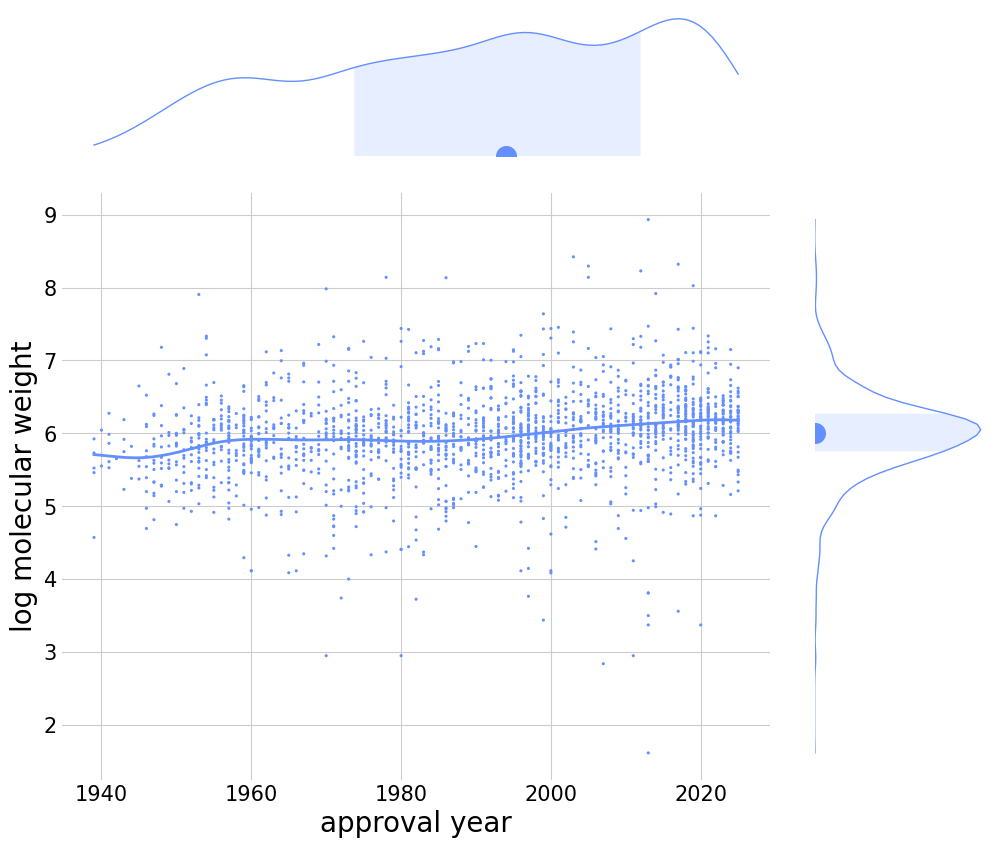

In [55]:
plot_scatter(compound_table.select('approval_year', 'log_molecular_weight').drop_nulls(), 'approval_year', 'log_molecular_weight')

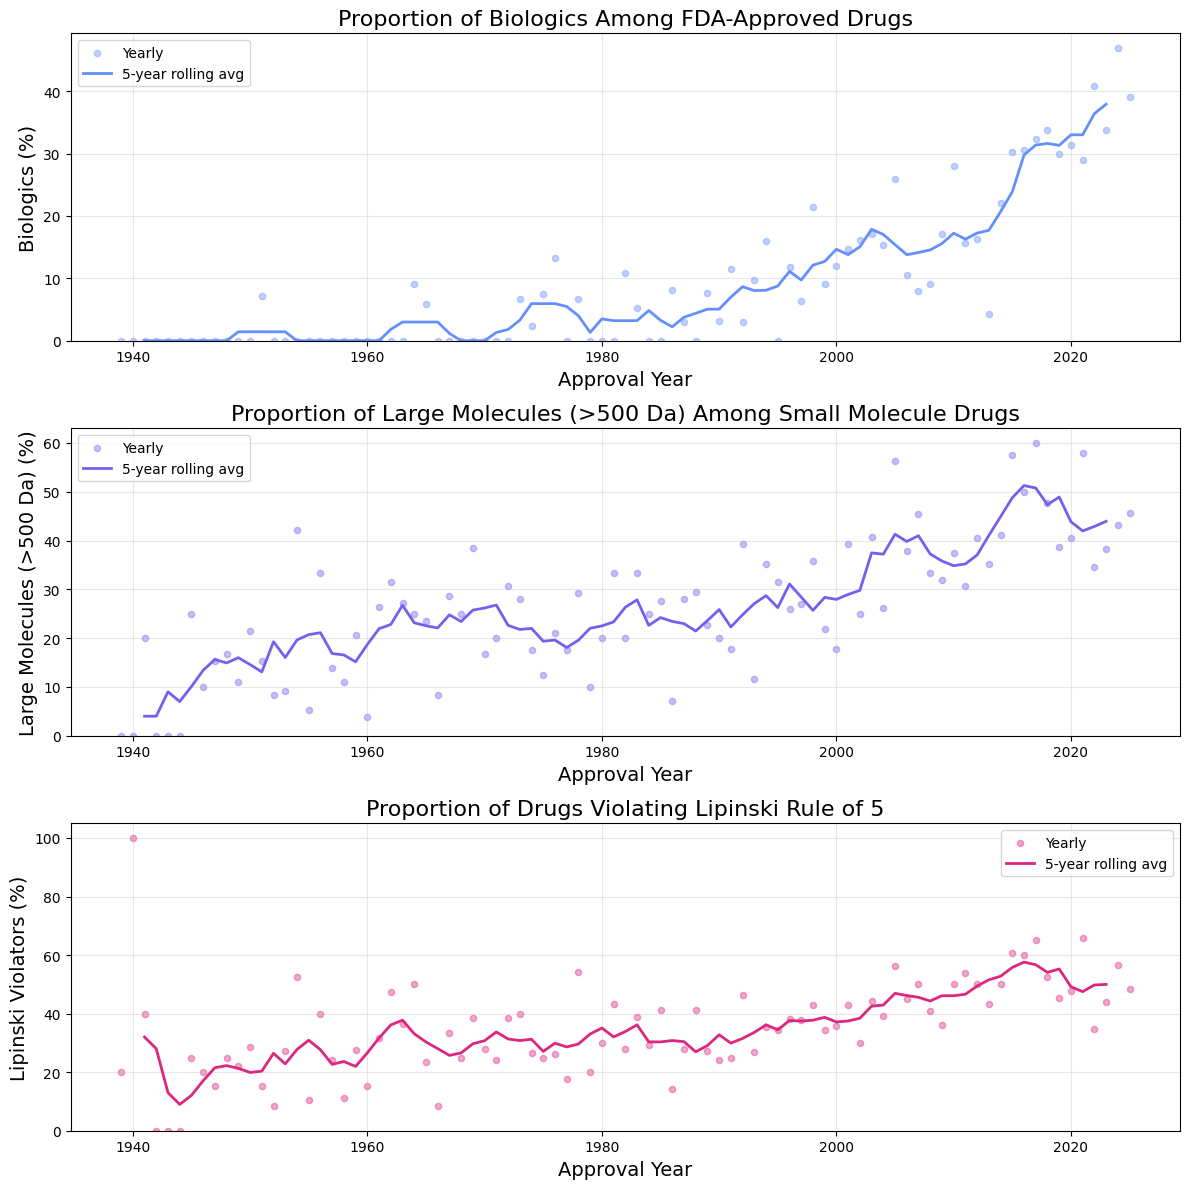


=== Summary Statistics ===

Biologics proportion:
  1980s avg: 3.5%
  2010s avg: 24.3%
  2020s avg: 36.8%

Large molecules (>500 Da) proportion:
  1980s avg: 24.7%
  2010s avg: 43.9%
  2020s avg: 43.4%

Lipinski violators proportion:
  1980s avg: 32.2%
  2010s avg: 53.1%
  2020s avg: 49.6%


In [58]:
# 1. Proportion of Biologics vs Small Molecules over time
# Use FDA summary table (includes ALL drugs, not just those with ChEMBL structures)
# FILTER FOR NOVEL APPLICATIONS ONLY (NDA + BLA) - excludes generics for innovation analysis
modality_by_year = (
    fda_summary
    .filter(pl.col('is_novel') == True)  # Only novel applications for innovation trends
    .select(['active_ingredient', 'approval_year', 'is_biologic'])
    .drop_nulls(['approval_year', 'is_biologic'])
    .group_by('approval_year')
    .agg([
        (pl.col('is_biologic') == True).sum().alias('biologics'),
        (pl.col('is_biologic') == False).sum().alias('small_molecules'),
    ])
    .sort('approval_year')
    .with_columns([
        (pl.col('biologics') + pl.col('small_molecules')).alias('total'),
    ])
    .with_columns([
        (pl.col('biologics') / pl.col('total') * 100).alias('biologic_pct'),
        (pl.col('small_molecules') / pl.col('total') * 100).alias('small_molecule_pct'),
    ])
    # Rolling 5-year average for smoother trend
    .with_columns([
        pl.col('biologic_pct').rolling_mean(window_size=5, center=True).alias('biologic_pct_rolling'),
    ])
)

# 2. Percentage of Large Molecules (>500 Da) among small molecules
large_mol_by_year = (
    compound_table
    .drop_nulls(['approval_year', 'molecular_weight'])
    .group_by('approval_year')
    .agg([
        (pl.col('molecular_weight') > 500).sum().alias('large_molecules'),
        pl.len().alias('total'),
    ])
    .sort('approval_year')
    .with_columns([
        (pl.col('large_molecules') / pl.col('total') * 100).alias('large_mol_pct'),
    ])
    .with_columns([
        pl.col('large_mol_pct').rolling_mean(window_size=5, center=True).alias('large_mol_pct_rolling'),
    ])
)

# 3. Percentage of Compounds Breaking Lipinski Rule (violations > 0)
lipinski_by_year = (
    compound_table
    .drop_nulls(['approval_year', 'lipinski_violations'])
    .group_by('approval_year')
    .agg([
        (pl.col('lipinski_violations') > 0).sum().alias('rule_breakers'),
        pl.len().alias('total'),
    ])
    .sort('approval_year')
    .with_columns([
        (pl.col('rule_breakers') / pl.col('total') * 100).alias('lipinski_violation_pct'),
    ])
    .with_columns([
        pl.col('lipinski_violation_pct').rolling_mean(window_size=5, center=True).alias('lipinski_violation_pct_rolling'),
    ])
)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

colors = IBM.colors

# Plot 1: Biologics proportion
ax1 = axes[0]
ax1.scatter(modality_by_year['approval_year'], modality_by_year['biologic_pct'], 
            s=20, alpha=0.4, color=colors[0], label='Yearly')
ax1.plot(modality_by_year['approval_year'], modality_by_year['biologic_pct_rolling'], 
         linewidth=2, color=colors[0], label='5-year rolling avg')
ax1.set_xlabel('Approval Year', fontsize=14)
ax1.set_ylabel('Biologics (%)', fontsize=14)
ax1.set_title('Proportion of Biologics Among FDA-Approved Drugs', fontsize=16)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, None)

# Plot 2: Large molecules (>500 Da)
ax2 = axes[1]
ax2.scatter(large_mol_by_year['approval_year'], large_mol_by_year['large_mol_pct'], 
            s=20, alpha=0.4, color=colors[1], label='Yearly')
ax2.plot(large_mol_by_year['approval_year'], large_mol_by_year['large_mol_pct_rolling'], 
         linewidth=2, color=colors[1], label='5-year rolling avg')
ax2.set_xlabel('Approval Year', fontsize=14)
ax2.set_ylabel('Large Molecules (>500 Da) (%)', fontsize=14)
ax2.set_title('Proportion of Large Molecules (>500 Da) Among Small Molecule Drugs', fontsize=16)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, None)

# Plot 3: Lipinski violations
ax3 = axes[2]
ax3.scatter(lipinski_by_year['approval_year'], lipinski_by_year['lipinski_violation_pct'], 
            s=20, alpha=0.4, color=colors[2], label='Yearly')
ax3.plot(lipinski_by_year['approval_year'], lipinski_by_year['lipinski_violation_pct_rolling'], 
         linewidth=2, color=colors[2], label='5-year rolling avg')
ax3.set_xlabel('Approval Year', fontsize=14)
ax3.set_ylabel('Lipinski Violators (%)', fontsize=14)
ax3.set_title('Proportion of Drugs Violating Lipinski Rule of 5', fontsize=16)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, None)

plt.tight_layout()
plt.show()

# Print summary stats
print("\n=== Summary Statistics ===")
print(f"\nBiologics proportion:")
print(f"  1980s avg: {modality_by_year.filter((pl.col('approval_year') >= 1980) & (pl.col('approval_year') < 1990))['biologic_pct'].mean():.1f}%")
print(f"  2010s avg: {modality_by_year.filter((pl.col('approval_year') >= 2010) & (pl.col('approval_year') < 2020))['biologic_pct'].mean():.1f}%")
print(f"  2020s avg: {modality_by_year.filter(pl.col('approval_year') >= 2020)['biologic_pct'].mean():.1f}%")

print(f"\nLarge molecules (>500 Da) proportion:")
print(f"  1980s avg: {large_mol_by_year.filter((pl.col('approval_year') >= 1980) & (pl.col('approval_year') < 1990))['large_mol_pct'].mean():.1f}%")
print(f"  2010s avg: {large_mol_by_year.filter((pl.col('approval_year') >= 2010) & (pl.col('approval_year') < 2020))['large_mol_pct'].mean():.1f}%")
print(f"  2020s avg: {large_mol_by_year.filter(pl.col('approval_year') >= 2020)['large_mol_pct'].mean():.1f}%")

print(f"\nLipinski violators proportion:")
print(f"  1980s avg: {lipinski_by_year.filter((pl.col('approval_year') >= 1980) & (pl.col('approval_year') < 1990))['lipinski_violation_pct'].mean():.1f}%")
print(f"  2010s avg: {lipinski_by_year.filter((pl.col('approval_year') >= 2010) & (pl.col('approval_year') < 2020))['lipinski_violation_pct'].mean():.1f}%")
print(f"  2020s avg: {lipinski_by_year.filter(pl.col('approval_year') >= 2020)['lipinski_violation_pct'].mean():.1f}%")

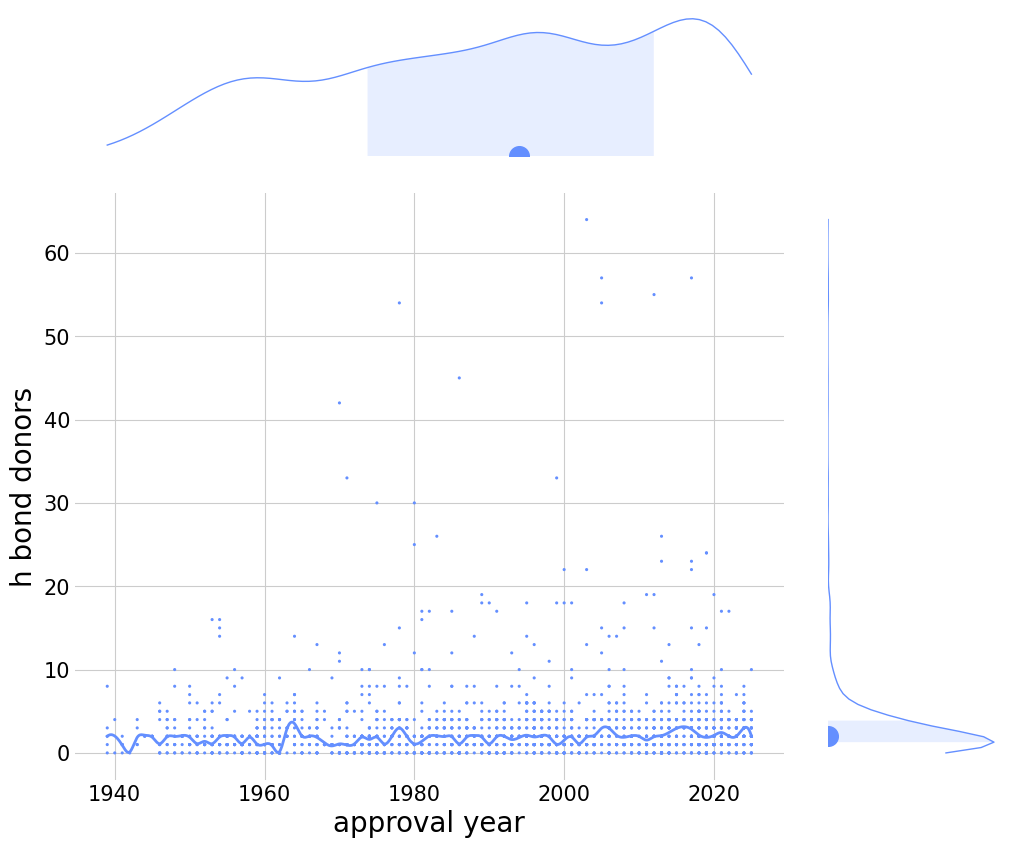

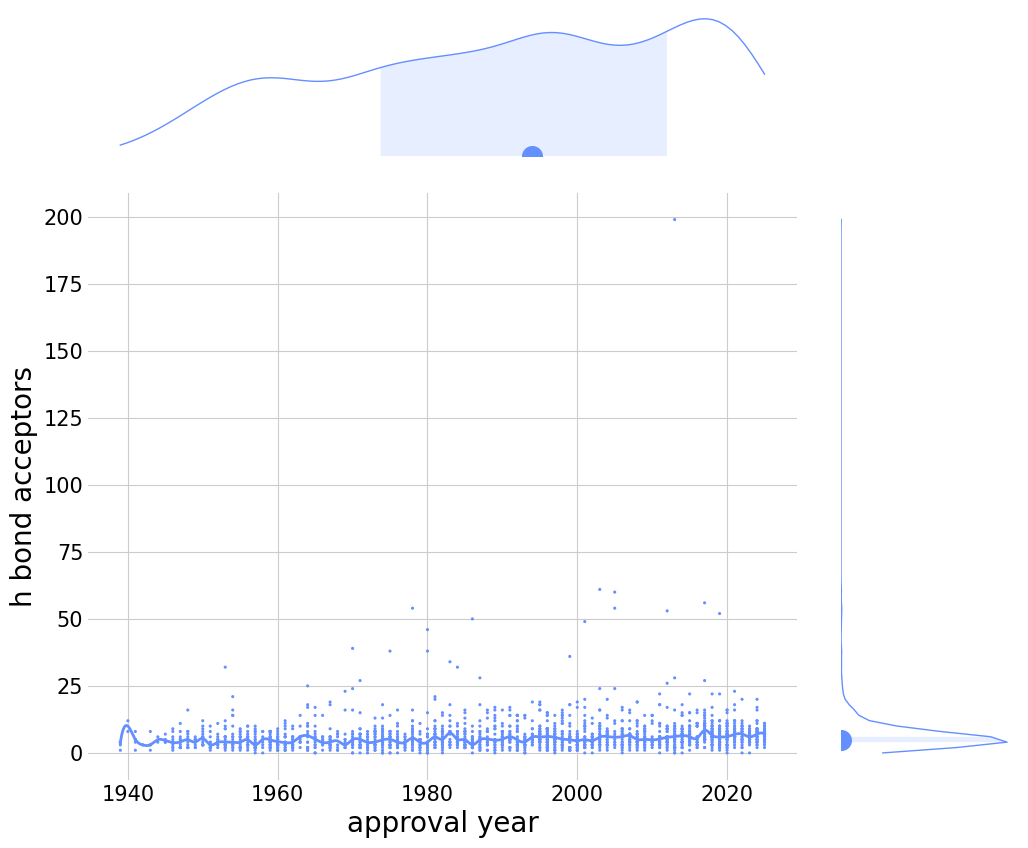

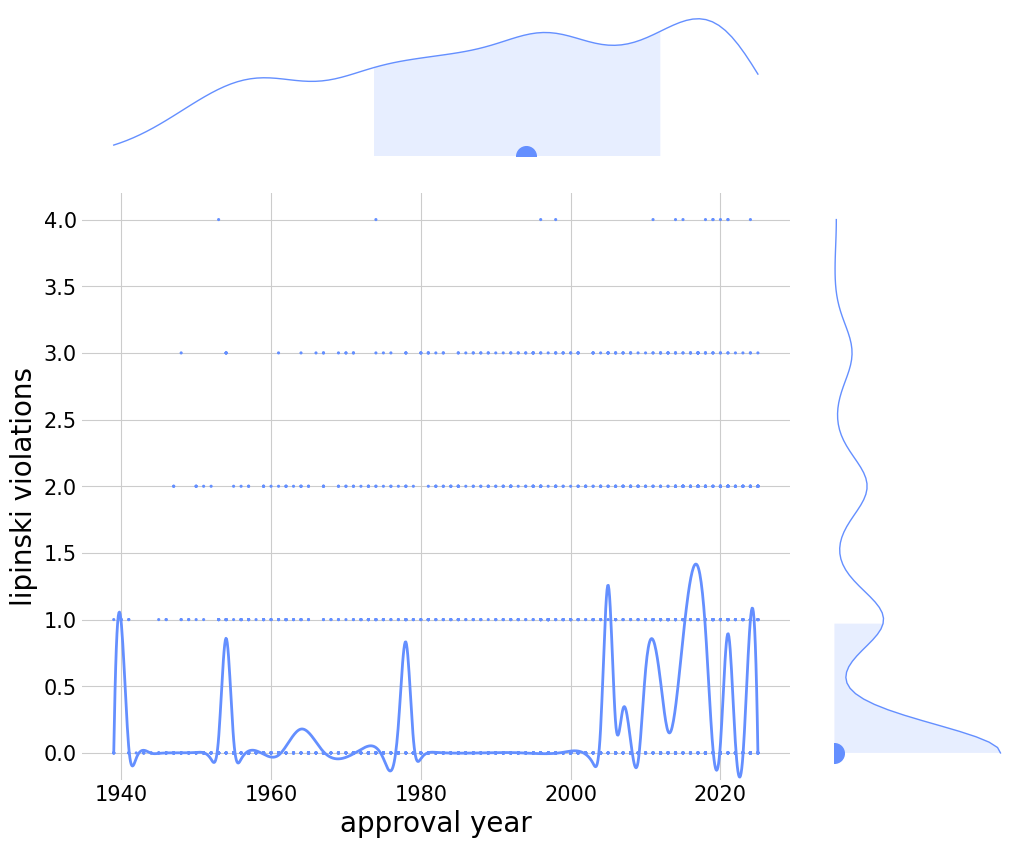

In [59]:
plot_scatter(compound_table.select('approval_year', 'h_bond_donors').drop_nulls(), 'approval_year', 'h_bond_donors')
plot_scatter(compound_table.select('approval_year', 'h_bond_acceptors').drop_nulls(), 'approval_year', 'h_bond_acceptors')
plot_scatter(compound_table.select('approval_year', 'lipinski_violations').drop_nulls(), 'approval_year', 'lipinski_violations')

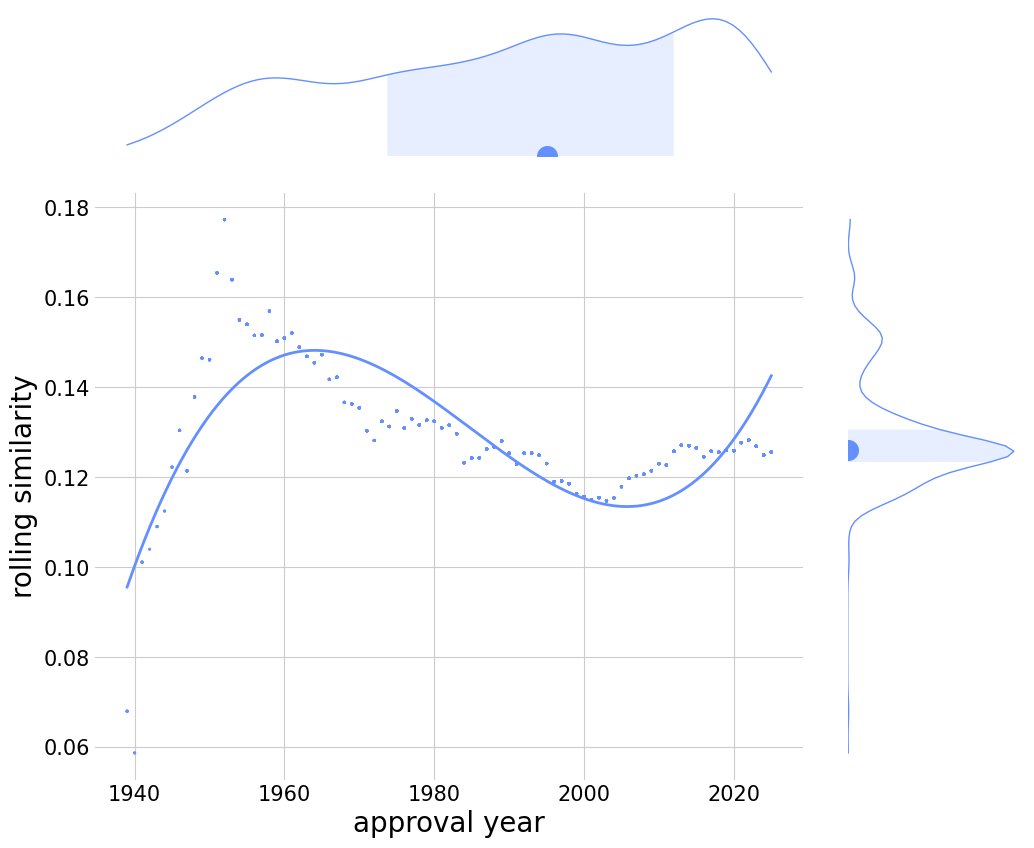

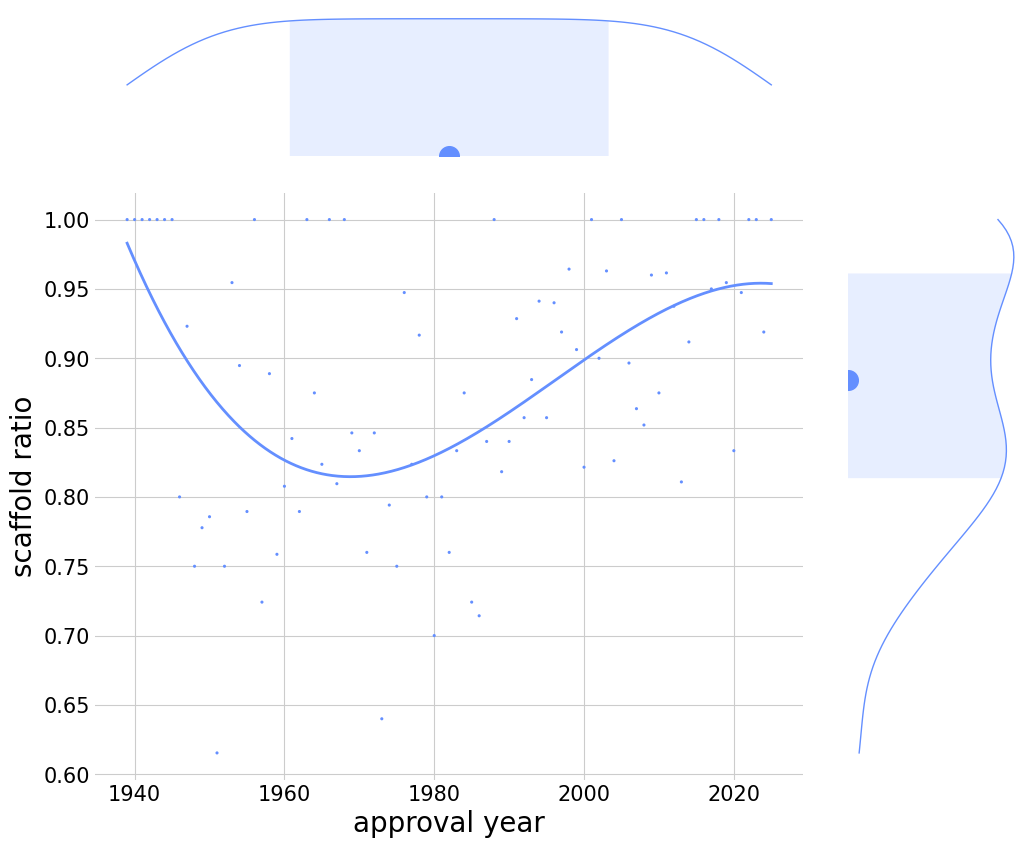

In [60]:
plot_scatter(scaffolds_table.select('approval_year', 'rolling_similarity').filter(pl.col('rolling_similarity').is_not_nan()), 'approval_year', 'rolling_similarity')
plot_scatter(scaffolds_ratio.select('approval_year', 'scaffold_ratio'), 'approval_year', 'scaffold_ratio')

=== Data Coverage Diagnostics ===

Target source distribution:
shape: (4, 2)
┌────────────────────┬──────────────┐
│ target_source      ┆ unique_drugs │
│ ---                ┆ ---          │
│ str                ┆ u32          │
╞════════════════════╪══════════════╡
│ chembl_moa         ┆ 1738         │
│ null               ┆ 283          │
│ chembl_bioactivity ┆ 48           │
│ open_targets       ┆ 35           │
└────────────────────┴──────────────┘

IUPHAR type values:
shape: (9, 2)
┌────────────────────┬──────────────┐
│ iuphar_type        ┆ unique_drugs │
│ ---                ┆ ---          │
│ str                ┆ u32          │
╞════════════════════╪══════════════╡
│ gpcr               ┆ 458          │
│ enzyme             ┆ 345          │
│ nhr                ┆ 150          │
│ transporter        ┆ 149          │
│ vgic               ┆ 115          │
│ lgic               ┆ 91           │
│ catalytic_receptor ┆ 73           │
│ other_protein      ┆ 27           │
│ other_ic    

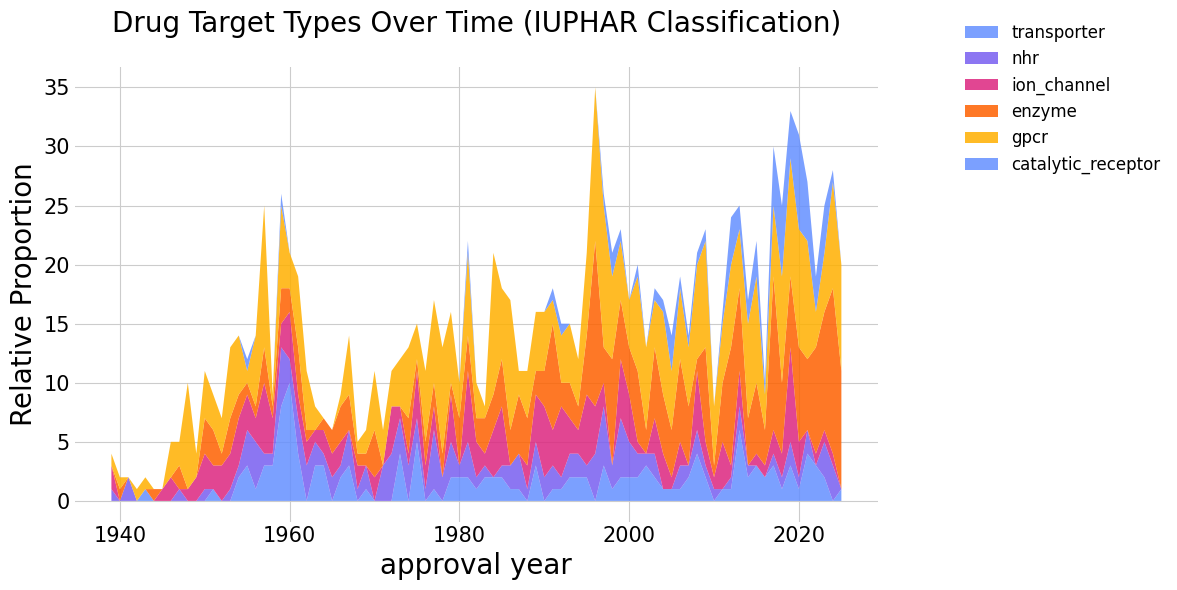

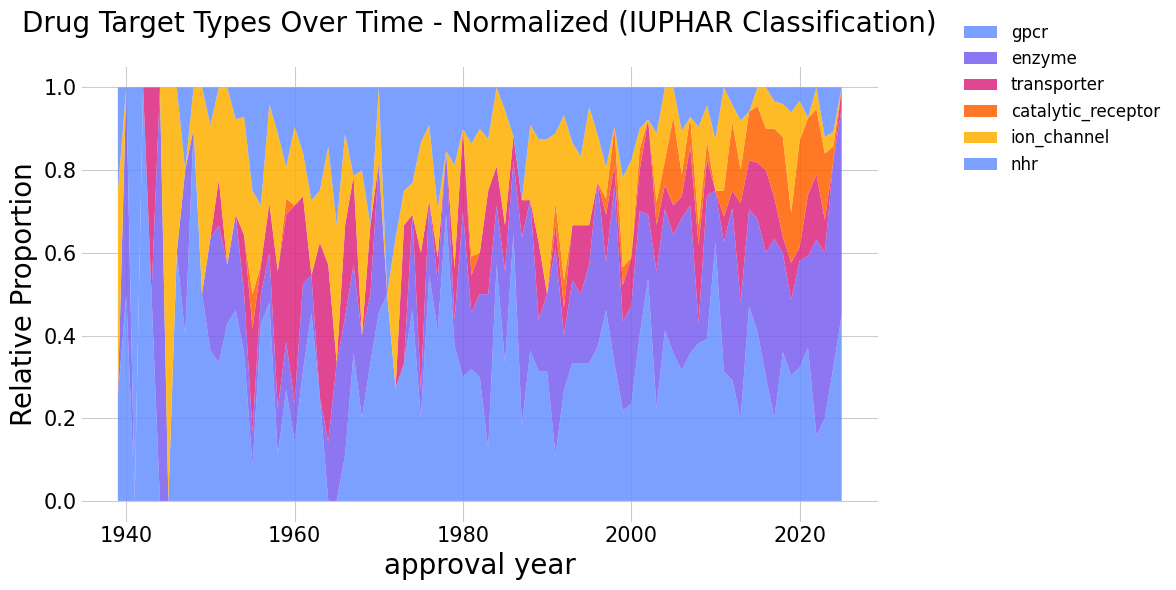


Decade-by-decade target type breakdown (%):
shape: (10, 7)
┌────────┬───────────┬───────────┬───────────┬─────────────┬────────────────────┬─────────────┐
│ decade ┆ gpcr      ┆ enzyme    ┆ nhr       ┆ ion_channel ┆ catalytic_receptor ┆ transporter │
│ ---    ┆ ---       ┆ ---       ┆ ---       ┆ ---         ┆ ---                ┆ ---         │
│ i32    ┆ f64       ┆ f64       ┆ f64       ┆ f64         ┆ f64                ┆ f64         │
╞════════╪═══════════╪═══════════╪═══════════╪═════════════╪════════════════════╪═════════════╡
│ 1930   ┆ 25.0      ┆ 0.0       ┆ 25.0      ┆ 50.0        ┆ 0.0                ┆ 0.0         │
│ 1940   ┆ 57.575758 ┆ 12.121212 ┆ 9.090909  ┆ 18.181818   ┆ 0.0                ┆ 3.030303    │
│ 1950   ┆ 34.285714 ┆ 15.0      ┆ 12.142857 ┆ 22.142857   ┆ 1.428571           ┆ 15.0        │
│ 1960   ┆ 23.584906 ┆ 16.981132 ┆ 18.867925 ┆ 16.037736   ┆ 0.0                ┆ 24.528302   │
│ 1970   ┆ 41.6      ┆ 12.0      ┆ 20.8      ┆ 16.0        ┆ 0.0            

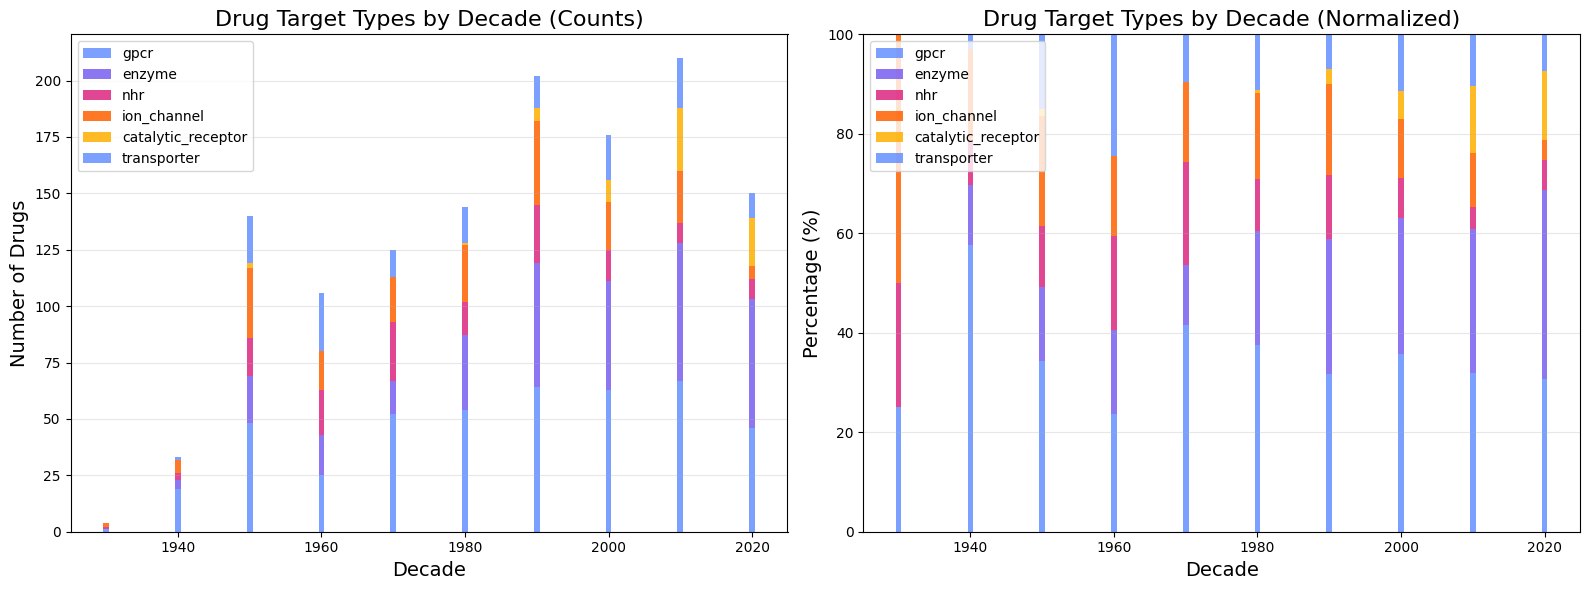

In [ ]:
def stream_graph(
    data: pl.DataFrame,
    feature_x: str,
    feature_y: str,
    id_col: str = 'active_ingredient',
    top_n: int = 8,
    normalize: bool = False,
    palette: list[str] | None = None,
    title: str | None = None
) -> None:
    """Plot a stream graph of the data.

    Parameters
    ----------
    data: pl.DataFrame
        Dataframe containing the data to plot
    feature_x: str
        Name of the feature to plot on the x-axis
    feature_y: str
        Name of the feature to plot on the y-axis
    id_col: str
        Name of the column to count unique values for
    top_n: int
        Number of top categories to show
    normalize: bool
        Whether to normalize the data
    palette: list[str]
        List of colors to use for the plot
    title: str
        Title of the plot
    """

    counts = (
        data.select([feature_x, feature_y, id_col])
        .drop_nulls([feature_x, feature_y])
        .unique()
        .group_by([feature_x, feature_y])
        .agg(pl.len().alias('count'))
    )
    
    top_categories = (
        counts.group_by(feature_y)
        .agg(pl.col('count').sum())
        .sort('count', descending=True)
        .head(top_n)[feature_y]
        .to_list()
    )
    
    pivoted = (
        counts.filter(pl.col(feature_y).is_in(top_categories))
        .pivot(index=feature_x, on=feature_y, values='count')
        .fill_null(0)
        .sort(feature_x)
    )
    
    x_values = pivoted[feature_x].to_numpy()
    categories = [col for col in pivoted.columns if col != feature_x]
    data_matrix = np.array([pivoted[cat].to_numpy() for cat in categories])

    range_x = [x_values.min(), x_values.max()]
    range_y = [0, data_matrix.sum(axis=0).max()]
    if normalize:
        row_sums = data_matrix.sum(axis=0)
        data_matrix = data_matrix / row_sums[np.newaxis, :]
        range_y = [0, 1]

    def margin(range): return (range[1]-range[0])*.05

    colors = palette or IBM.colors

    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(1, 1)
    ax_stream = fig.add_subplot(gs[0, 0])

    plt.sca(ax_stream)
    ax_stream.set_facecolor("white")
    ax_stream.grid(color="#cccccc")
    ax_stream.set_axisbelow(True)
    plt.box(False)
    ax_stream.ticklabel_format(axis="both", style="sci")
    ax_stream.tick_params(axis="both", which="both", length=0)

    ax_stream.stackplot(x_values, data_matrix, labels=categories, colors=colors,
                        alpha=0.85, baseline='zero', edgecolor='none')

    ax_stream.set_xlim([range_x[0]-margin(range_x), range_x[1]+margin(range_x)])
    ax_stream.set_ylim([range_y[0]-margin(range_y), range_y[1]+margin(range_y)])
    ax_stream.tick_params(axis='x', labelsize=15)
    ax_stream.tick_params(axis='y', labelsize=15)
    ax_stream.set_xlabel(fill(feature_x.replace('_', ' '), width=25), fontsize=20)
    ax_stream.set_ylabel('Relative Proportion', fontsize=20)

    ax_stream.legend(loc=(1.1, 0.75), fontsize=12, frameon=False, ncol=1)

    if title:
        plt.title(title, fontsize=20, pad=25)

    plt.tight_layout()
    plt.show()


# ============================================
# TARGET TREND ANALYSIS - Diagnostics & Plots
# ============================================

# First, let's understand the data coverage
print("=== Data Coverage Diagnostics ===\n")

# 1. Target source distribution
print("Target source distribution:")
source_dist = drug_table.group_by("target_source").agg(
    pl.col("active_ingredient").n_unique().alias("unique_drugs")
).sort("unique_drugs", descending=True)
print(source_dist)

# 2. IUPHAR type values (note: kinases are under "enzyme")
print("\nIUPHAR type values:")
iuphar_types = drug_table.filter(pl.col("iuphar_type").is_not_null()).group_by("iuphar_type").agg(
    pl.col("active_ingredient").n_unique().alias("unique_drugs")
).sort("unique_drugs", descending=True)
print(iuphar_types)

# 3. Coverage stats
total_drugs = drug_table["active_ingredient"].n_unique()
drugs_with_moa = drug_table.filter(pl.col("target_source") == "chembl_moa")["active_ingredient"].n_unique()
drugs_with_iuphar = drug_table.filter(pl.col("iuphar_type").is_not_null())["active_ingredient"].n_unique()
drugs_moa_and_iuphar = drug_table.filter(
    (pl.col("target_source") == "chembl_moa") & (pl.col("iuphar_type").is_not_null())
)["active_ingredient"].n_unique()

print(f"\nCoverage summary:")
print(f"  Total drugs in ChEMBL table: {total_drugs}")
print(f"  With ChEMBL MOA: {drugs_with_moa} ({drugs_with_moa/total_drugs*100:.1f}%)")
print(f"  With IUPHAR type: {drugs_with_iuphar} ({drugs_with_iuphar/total_drugs*100:.1f}%)")
print(f"  With BOTH MOA + IUPHAR: {drugs_moa_and_iuphar} ({drugs_moa_and_iuphar/total_drugs*100:.1f}%)")

# ============================================
# IMPROVED TARGET TREND ANALYSIS
# ============================================
print("\n" + "="*50)
print("TARGET TREND ANALYSIS")
print("="*50)

# Filter for established mechanisms only (less noisy than bioactivity fallback)
# Include both chembl_moa and open_targets for better coverage
target_trend_data = (
    drug_table
    .filter(pl.col("target_source").is_in(["chembl_moa", "open_targets"]))
    .select(['active_ingredient', 'approval_year', 'iuphar_type', 'iuphar_family'])
    .drop_nulls(['approval_year', 'iuphar_type'])
    .with_columns(
    pl.when(pl.col("iuphar_type").is_in(["lgic", "vgic"]))
    .then(pl.lit("ion_channel"))
    .otherwise(pl.col("iuphar_type"))
    .alias("iuphar_type")
    )
    .unique()
    .with_columns(
        ((pl.col("approval_year") // 10) * 10).alias("decade")
    )
)

print(f"\nFiltered target data: {target_trend_data['active_ingredient'].n_unique()} unique drugs")
print(f"  with {target_trend_data.height} drug-target-year combinations")

# Stream graph using iuphar_type (broad categories)
# Note: kinases are classified under "enzyme" in IUPHAR
stream_graph(
    target_trend_data, 
    'approval_year', 
    'iuphar_type', 
    id_col='active_ingredient',
    top_n=6, 
    normalize=False, 
    title='Drug Target Types Over Time (IUPHAR Classification)'
)

stream_graph(
    target_trend_data, 
    'approval_year', 
    'iuphar_type', 
    id_col='active_ingredient',
    top_n=6, 
    normalize=True, 
    title='Drug Target Types Over Time - Normalized (IUPHAR Classification)'
)

# Decade-based stacked bar chart for cleaner visualization
decade_counts = (
    target_trend_data
    .group_by(["decade", "iuphar_type"])
    .agg(pl.col("active_ingredient").n_unique().alias("count"))
)

# Get top target types
top_types = (
    decade_counts.group_by("iuphar_type")
    .agg(pl.col("count").sum())
    .sort("count", descending=True)
    .head(6)["iuphar_type"].to_list()
)

# Pivot for plotting
decade_pivot = (
    decade_counts
    .filter(pl.col("iuphar_type").is_in(top_types))
    .pivot(index="decade", on="iuphar_type", values="count")
    .fill_null(0)
    .sort("decade")
)

# Calculate percentages within each decade
decade_pct = decade_pivot.select("decade")
for col in [c for c in decade_pivot.columns if c != "decade"]:
    total = decade_pivot.select([pl.col(c) for c in decade_pivot.columns if c != "decade"]).sum_horizontal()
    decade_pct = decade_pct.with_columns(
        (decade_pivot[col] / total * 100).alias(col)
    )

print("\nDecade-by-decade target type breakdown (%):")
print(decade_pct)

# Plot decade bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
decades = decade_pivot["decade"].to_numpy()
bottom = np.zeros(len(decades))
colors = IBM.colors

ax1 = axes[0]
for i, col in enumerate([c for c in decade_pivot.columns if c != "decade"]):
    values = decade_pivot[col].to_numpy()
    ax1.bar(decades, values, bottom=bottom, label=col, color=colors[i % len(colors)], alpha=0.85)
    bottom += values

ax1.set_xlabel("Decade", fontsize=14)
ax1.set_ylabel("Number of Drugs", fontsize=14)
ax1.set_title("Drug Target Types by Decade (Counts)", fontsize=16)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Percentages (100% stacked)
bottom = np.zeros(len(decades))
ax2 = axes[1]
for i, col in enumerate([c for c in decade_pct.columns if c != "decade"]):
    values = decade_pct[col].to_numpy()
    ax2.bar(decades, values, bottom=bottom, label=col, color=colors[i % len(colors)], alpha=0.85)
    bottom += values

ax2.set_xlabel("Decade", fontsize=14)
ax2.set_ylabel("Percentage (%)", fontsize=14)
ax2.set_title("Drug Target Types by Decade (Normalized)", fontsize=16)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# ============================================
# TARGET TREND SUMMARY
# ============================================
print("\n" + "="*60)
print("TARGET TYPE TREND SUMMARY")
print("="*60)

# Compare early period (1980-1999) vs recent period (2010-2025)
early_decades = [1980, 1990]
recent_decades = [2010, 2020]

early_data = decade_pct.filter(pl.col("decade").is_in(early_decades))
recent_data = decade_pct.filter(pl.col("decade").is_in(recent_decades))

target_cols = [c for c in decade_pct.columns if c != "decade"]

print(f"\nComparing early period (1980s-1990s) vs recent period (2010s-2020s):\n")
print(f"{'Target Type':<22} {'Early Avg %':>12} {'Recent Avg %':>12} {'Change':>10} {'Trend':>12}")
print("-" * 70)

trends = []
for col in target_cols:
    early_avg = early_data[col].mean() if not early_data.is_empty() else 0
    recent_avg = recent_data[col].mean() if not recent_data.is_empty() else 0
    change = recent_avg - early_avg
    
    if abs(change) < 3:
        trend = "STABLE"
        symbol = "→"
    elif change > 0:
        trend = "INCREASED"
        symbol = "↑"
    else:
        trend = "DECREASED"
        symbol = "↓"
    
    trends.append({
        "target": col,
        "early_avg": early_avg,
        "recent_avg": recent_avg,
        "change": change,
        "trend": trend,
        "symbol": symbol
    })
    
    print(f"{col:<22} {early_avg:>11.1f}% {recent_avg:>11.1f}% {change:>+9.1f}% {symbol} {trend}")

# Summary insights
print("\n" + "-" * 70)
print("\nKEY INSIGHTS:")
increased = [t for t in trends if t["trend"] == "INCREASED"]
decreased = [t for t in trends if t["trend"] == "DECREASED"]
stable = [t for t in trends if t["trend"] == "STABLE"]

if increased:
    print(f"  ↑ Rising:  {', '.join([t['target'] for t in increased])}")
if decreased:
    print(f"  ↓ Falling: {', '.join([t['target'] for t in decreased])}")
if stable:
    print(f"  → Stable:  {', '.join([t['target'] for t in stable])}")

# Most dramatic changes
if trends:
    biggest_gainer = max(trends, key=lambda x: x["change"])
    biggest_loser = min(trends, key=lambda x: x["change"])
    print(f"\n  Biggest increase: {biggest_gainer['target']} (+{biggest_gainer['change']:.1f}%)")
    print(f"  Biggest decrease: {biggest_loser['target']} ({biggest_loser['change']:.1f}%)")

In [12]:
drug_table

action_type,active_ingredient,canonical_smiles,component_name,component_type,max_phase,mechanism_of_action,molecule_chembl_id,pref_name,standard_inchi_key,target_chembl_id,target_source,target_type,uniprot_id,first_approval_date,approval_status,is_biologic,target_type_pc,panther_family,interpro_domain,pfam_family,iuphar_type,iuphar_family,iuphar_target,approval_year,molecular_weight,logp,h_bond_donors,h_bond_acceptors,lipinski_violations,scaffold_smiles
str,str,str,str,str,str,str,str,str,str,str,str,str,str,date,str,bool,str,str,str,str,str,str,str,i32,f64,f64,i64,i64,i64,str
"""INHIBITOR""","""abacavir""","""Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C…","""Reverse transcriptase/RNaseH""","""PROTEIN""","""4.0""","""Human immunodeficiency virus t…","""CHEMBL4303288""","""Human immunodeficiency virus t…","""WMHSRBZIJNQHKT-FFKFEZPRSA-N""","""CHEMBL247""","""chembl_moa""","""SINGLE PROTEIN""","""Q72547""",2006-07-26,"""TA""",false,"""SINGLE PROTEIN""","""ENDOGENOUS RETROVIRUS GROUP K …","""RT_dom""","""RNase_H""",null,null,null,2006,670.757,1.5318,8,16,3,"""C1=C[C@H](n2cnc3c(NC4CC4)ncnc3…"
"""INHIBITOR""","""abacavir sulfate""","""Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C…","""Reverse transcriptase/RNaseH""","""PROTEIN""","""4.0""","""Human immunodeficiency virus t…","""CHEMBL4303288""","""Human immunodeficiency virus t…","""WMHSRBZIJNQHKT-FFKFEZPRSA-N""","""CHEMBL247""","""chembl_moa""","""SINGLE PROTEIN""","""Q72547""",1998-12-17,"""AP""",false,"""SINGLE PROTEIN""","""ENDOGENOUS RETROVIRUS GROUP K …","""RT_dom""","""RNase_H""",null,null,null,1998,670.757,1.5318,8,16,3,"""C1=C[C@H](n2cnc3c(NC4CC4)ncnc3…"
"""ANTAGONIST""","""abarelix""","""CC(=O)N[C@H](Cc1ccc2ccccc2c1)C…","""Gonadotropin-releasing hormone…","""PROTEIN""","""4.0""","""Gonadotropin-releasing hormone…","""CHEMBL1252""","""Gonadotropin-releasing hormone…","""AIWRTTMUVOZGPW-HSPKUQOVSA-N""","""CHEMBL1855""","""chembl_moa""","""SINGLE PROTEIN""","""P30968""",2003-11-25,"""AP""",false,"""SINGLE PROTEIN""","""GONADOTROPIN-RELEASING HORMONE…","""GPCR_Rhodpsn""","""7tm_1""","""gpcr""","""Gonadotrophin-releasing hormon…","""GnRH<sub>1</sub> receptor""",2003,1416.089,1.168,13,16,3,"""O=C(CNC(=O)CNC(=O)[C@H](Cc1ccc…"
"""INHIBITOR""","""abemaciclib""","""CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4c…","""Cyclin-dependent kinase 4""","""PROTEIN""","""4.0""","""Cyclin-dependent kinase 4 inhi…","""CHEMBL3301610""","""Cyclin-dependent kinase 4""","""UZWDCWONPYILKI-UHFFFAOYSA-N""","""CHEMBL331""","""chembl_moa""","""SINGLE PROTEIN""","""P11802""",2017-09-28,"""AP""",false,"""SINGLE PROTEIN""","""CELL DIVISION PROTEIN KINASE""","""CDK""","""Pkinase""","""enzyme""","""CDK4 subfamily""","""cyclin dependent kinase 4""",2017,506.605,4.93692,1,8,1,"""c1cc(-c2ccc3nc[nH]c3c2)nc(Nc2c…"
"""INHIBITOR""","""abemaciclib""","""CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4c…","""Cyclin-dependent kinase 6""","""PROTEIN""","""4.0""","""Cyclin-dependent kinase 6 inhi…","""CHEMBL3301610""","""Cyclin-dependent kinase 6""","""UZWDCWONPYILKI-UHFFFAOYSA-N""","""CHEMBL2508""","""chembl_moa""","""SINGLE PROTEIN""","""Q00534""",2017-09-28,"""AP""",false,"""SINGLE PROTEIN""","""CELL DIVISION PROTEIN KINASE""","""CDK""","""Pkinase""","""enzyme""","""CDK4 subfamily""","""cyclin dependent kinase 6""",2017,506.605,4.93692,1,8,1,"""c1cc(-c2ccc3nc[nH]c3c2)nc(Nc2c…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""POSITIVE ALLOSTERIC MODULATOR""","""zuranolone""","""C[C@@]1(O)CC[C@H]2[C@H](CC[C@@…","""Gamma-aminobutyric acid recept…","""PROTEIN""","""4.0""","""GABA-A receptor; anion channel…","""CHEMBL4105630""","""GABA-A receptor; anion channel""","""HARRKNSQXBRBGZ-GVKWWOCJSA-N""","""CHEMBL2093872""","""chembl_moa""","""PROTEIN COMPLEX GROUP""","""P18505""",2023-08-04,"""AP""",false,"""PROTEIN COMPLEX GROUP""","""NEUROTRANSMITTER GATED ION CHA…","""GABAAa_rcpt""","""Neur_chan_LBD""","""lgic""","""GABA<sub>A</sub> receptors""","""GABA<sub>A</sub> receptor &bet…",2023,409.574,4.34368,1,5,0,"""O=C(Cn1cccn1)[C@H]1CC[C@@H]2C1…"
"""POSITIVE ALLOSTERIC MODULAT